# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

The tests are performed for model trained on tokenization with info about x and y coordinates and player (88 tokens)

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-full'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.66M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(88, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=88, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom, separator = meta['stoi'], meta['itos'], meta['stom'], meta['separator']
split = lambda s: list(s) if separator == '' else s.split(separator)
encode = lambda s: [stoi[c] for c in split(s)]
decode = lambda l: separator.join(itos[i] for i in l)
str_to_moves = lambda s: ''.join(stom[c] for c in split(s))
ids_to_moves = lambda l: ''.join(stom[itos[i]] for i in l)

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [6]:
def test_legal_move_and_game_result_prediction(data):
    move_seqs = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_moves = ids_to_moves(seq)
        for i in range(len(seq)):
            engine.make_move(seq_moves[i])

            if seq_moves[:i+1] in move_seqs:
                continue
            move_seqs.add(seq_moves[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = ids_to_moves(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [7]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [8]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59454/59665 (99.65%)
Game result predicted (validation data): 1800/2000 (90.00%)


In [9]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [10]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 497649/498639 (99.80%)
Game result predicted (training data): 17053/18000 (94.74%)


## Probing

### Get output from hidden layers of the model

In [11]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [12]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = []
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = torch.stack(X)
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [13]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [14]:
train_X.shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [15]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [16]:
val_X.shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

### Train linear probes

In [17]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [18]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [19]:
def train_probe(X, Y, num_cls):
    probe = LinearBoardProbe(dim_x=X.shape[-1], dim_y=Y.shape[-1], num_cls=num_cls).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        probe.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    epochs = 1024
    batch_size = 1024

    train_loader = get_data_loader(X, Y, batch_size)

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)

            loss = criterion(
                preds.view(-1, probe._num_cls),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

    return probe, train_loader

Predict value of each cell

In [20]:
cell_probe, cell_train_loader = train_probe(train_X, train_Y_cell, num_cls=3)

Epoch   0: 1.3554
Epoch   1: 0.9705
Epoch   2: 0.7846
Epoch   3: 0.6717
Epoch   4: 0.5973
Epoch   5: 0.5453
Epoch   6: 0.5070
Epoch   7: 0.4778
Epoch   8: 0.4546
Epoch   9: 0.4357
Epoch  10: 0.4199
Epoch  11: 0.4066
Epoch  12: 0.3952
Epoch  13: 0.3852
Epoch  14: 0.3764
Epoch  15: 0.3685
Epoch  16: 0.3616
Epoch  17: 0.3552
Epoch  18: 0.3495
Epoch  19: 0.3443
Epoch  20: 0.3394
Epoch  21: 0.3350
Epoch  22: 0.3308
Epoch  23: 0.3269
Epoch  24: 0.3234
Epoch  25: 0.3199
Epoch  26: 0.3168
Epoch  27: 0.3138
Epoch  28: 0.3110
Epoch  29: 0.3083
Epoch  30: 0.3057
Epoch  31: 0.3034
Epoch  32: 0.3010
Epoch  33: 0.2988
Epoch  34: 0.2968
Epoch  35: 0.2947
Epoch  36: 0.2928
Epoch  37: 0.2910
Epoch  38: 0.2892
Epoch  39: 0.2875
Epoch  40: 0.2858
Epoch  41: 0.2843
Epoch  42: 0.2826
Epoch  43: 0.2811
Epoch  44: 0.2798
Epoch  45: 0.2783
Epoch  46: 0.2771
Epoch  47: 0.2757
Epoch  48: 0.2745
Epoch  49: 0.2732
Epoch  50: 0.2721
Epoch  51: 0.2709
Epoch  52: 0.2698
Epoch  53: 0.2686
Epoch  54: 0.2676
Epoch  55:

Predict number of pieces in each column

In [21]:
col_probe, col_train_loader = train_probe(train_X, train_Y_col, num_cls=7)

Epoch   0: 2.2140
Epoch   1: 1.5477
Epoch   2: 1.1280
Epoch   3: 0.8527
Epoch   4: 0.6739
Epoch   5: 0.5550
Epoch   6: 0.4731
Epoch   7: 0.4136
Epoch   8: 0.3692
Epoch   9: 0.3345
Epoch  10: 0.3068
Epoch  11: 0.2840
Epoch  12: 0.2650
Epoch  13: 0.2489
Epoch  14: 0.2353
Epoch  15: 0.2231
Epoch  16: 0.2125
Epoch  17: 0.2032
Epoch  18: 0.1947
Epoch  19: 0.1871
Epoch  20: 0.1804
Epoch  21: 0.1742
Epoch  22: 0.1686
Epoch  23: 0.1632
Epoch  24: 0.1584
Epoch  25: 0.1539
Epoch  26: 0.1497
Epoch  27: 0.1459
Epoch  28: 0.1423
Epoch  29: 0.1389
Epoch  30: 0.1357
Epoch  31: 0.1326
Epoch  32: 0.1297
Epoch  33: 0.1272
Epoch  34: 0.1246
Epoch  35: 0.1222
Epoch  36: 0.1198
Epoch  37: 0.1177
Epoch  38: 0.1156
Epoch  39: 0.1135
Epoch  40: 0.1117
Epoch  41: 0.1099
Epoch  42: 0.1081
Epoch  43: 0.1065
Epoch  44: 0.1049
Epoch  45: 0.1033
Epoch  46: 0.1017
Epoch  47: 0.1004
Epoch  48: 0.0989
Epoch  49: 0.0975
Epoch  50: 0.0963
Epoch  51: 0.0950
Epoch  52: 0.0938
Epoch  53: 0.0927
Epoch  54: 0.0915
Epoch  55:

Predict number of pieces in each row

In [22]:
row_probe, row_train_loader = train_probe(train_X, train_Y_row, num_cls=8)

Epoch   0: 2.4366
Epoch   1: 1.8718
Epoch   2: 1.6029
Epoch   3: 1.4384
Epoch   4: 1.3271
Epoch   5: 1.2472
Epoch   6: 1.1875
Epoch   7: 1.1403
Epoch   8: 1.1022
Epoch   9: 1.0699
Epoch  10: 1.0430
Epoch  11: 1.0196
Epoch  12: 0.9986
Epoch  13: 0.9798
Epoch  14: 0.9634
Epoch  15: 0.9484
Epoch  16: 0.9344
Epoch  17: 0.9215
Epoch  18: 0.9097
Epoch  19: 0.8989
Epoch  20: 0.8882
Epoch  21: 0.8785
Epoch  22: 0.8695
Epoch  23: 0.8609
Epoch  24: 0.8527
Epoch  25: 0.8449
Epoch  26: 0.8376
Epoch  27: 0.8304
Epoch  28: 0.8236
Epoch  29: 0.8171
Epoch  30: 0.8113
Epoch  31: 0.8049
Epoch  32: 0.7994
Epoch  33: 0.7936
Epoch  34: 0.7883
Epoch  35: 0.7832
Epoch  36: 0.7784
Epoch  37: 0.7733
Epoch  38: 0.7688
Epoch  39: 0.7643
Epoch  40: 0.7599
Epoch  41: 0.7559
Epoch  42: 0.7516
Epoch  43: 0.7475
Epoch  44: 0.7436
Epoch  45: 0.7396
Epoch  46: 0.7363
Epoch  47: 0.7323
Epoch  48: 0.7291
Epoch  49: 0.7257
Epoch  50: 0.7222
Epoch  51: 0.7190
Epoch  52: 0.7156
Epoch  53: 0.7125
Epoch  54: 0.7092
Epoch  55:

### Test linear probes

In [23]:
def eval_probe(probe, loader, dim):
    correct = torch.zeros(dim, device=DEVICE)
    total = torch.zeros(dim, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [24]:
def plot_heatmap(acc, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False):
    board = acc.view(h, w).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if disable_yticks:
        plt.yticks([])
    if disable_xticks:
        plt.xticks([])

    for i in range(h):
        for j in range(w):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

Per cell

In [25]:
train_acc_cell = eval_probe(cell_probe, cell_train_loader, dim=train_Y_cell.shape[-1])
train_acc_cell

tensor([0.9157, 0.9207, 0.9200, 0.9398, 0.9423, 0.9657, 0.9781, 0.8932, 0.9041,
        0.9096, 0.9476, 0.9413, 0.9474, 0.9704, 0.8685, 0.9092, 0.9307, 0.9668,
        0.9442, 0.9289, 0.9469, 0.8591, 0.9399, 0.9758, 0.9854, 0.9715, 0.9282,
        0.9232, 0.8604, 0.8929, 0.9493, 0.9899, 0.9411, 0.9155, 0.9178, 0.8385,
        0.8457, 0.8274, 0.9479, 0.8268, 0.8363, 0.8674], device='cuda:0')

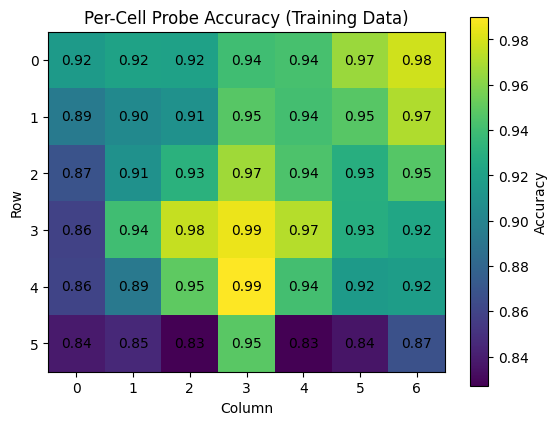

In [26]:
plot_heatmap(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [27]:
cell_val_loader = get_data_loader(val_X, val_Y_cell)
val_acc_cell = eval_probe(cell_probe, cell_val_loader, val_Y_cell.shape[-1])
val_acc_cell

tensor([0.8922, 0.9043, 0.9086, 0.9223, 0.9223, 0.9434, 0.9699, 0.8726, 0.8938,
        0.9033, 0.9413, 0.9202, 0.9334, 0.9551, 0.8658, 0.8969, 0.9186, 0.9514,
        0.9387, 0.9101, 0.9350, 0.8356, 0.9228, 0.9651, 0.9794, 0.9619, 0.9144,
        0.9123, 0.8568, 0.8853, 0.9355, 0.9836, 0.9308, 0.8916, 0.9006, 0.8245,
        0.8224, 0.8266, 0.9482, 0.7970, 0.8251, 0.8451], device='cuda:0')

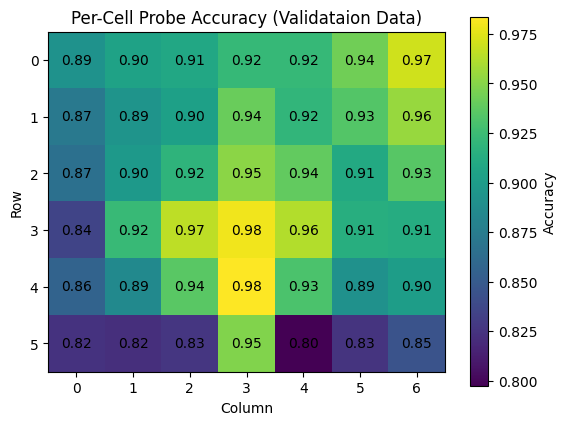

In [28]:
plot_heatmap(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [29]:
train_acc_col = eval_probe(col_probe, col_train_loader, dim=train_Y_col.shape[-1])
train_acc_col

tensor([0.9972, 0.9968, 0.9956, 0.9985, 0.9993, 0.9982, 0.9982],
       device='cuda:0')

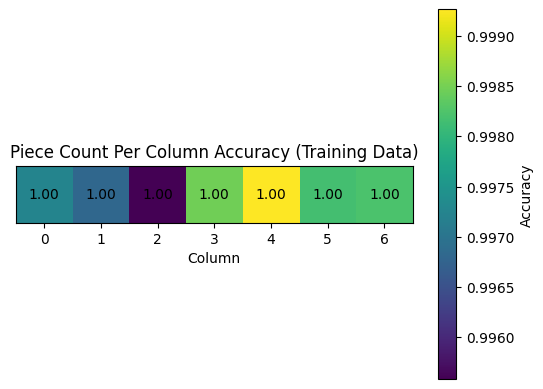

In [30]:
plot_heatmap(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [31]:
col_val_loader = get_data_loader(val_X, val_Y_col)
val_acc_col = eval_probe(col_probe, col_val_loader, val_Y_col.shape[-1])
val_acc_col

tensor([0.9889, 0.9878, 0.9820, 0.9910, 0.9889, 0.9905, 0.9863],
       device='cuda:0')

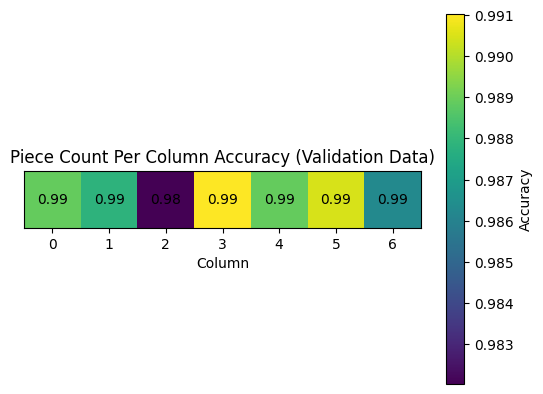

In [32]:
plot_heatmap(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [33]:
train_acc_row = eval_probe(row_probe, row_train_loader, dim=train_Y_row.shape[-1])
train_acc_row

tensor([0.8775, 0.8371, 0.8226, 0.8331, 0.8576, 0.8962], device='cuda:0')

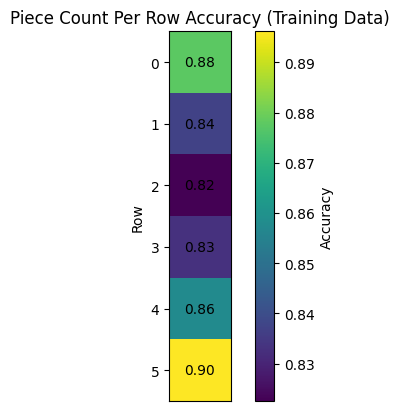

In [34]:
plot_heatmap(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [35]:
row_val_loader = get_data_loader(val_X, val_Y_row)
val_acc_row = eval_probe(row_probe, row_val_loader, val_Y_row.shape[-1])
val_acc_row

tensor([0.8414, 0.7965, 0.7558, 0.7875, 0.8208, 0.8647], device='cuda:0')

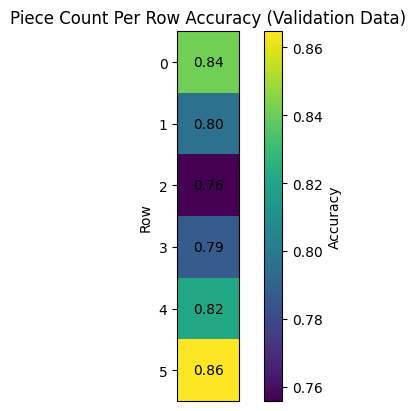

In [36]:
plot_heatmap(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)